## DenseNet

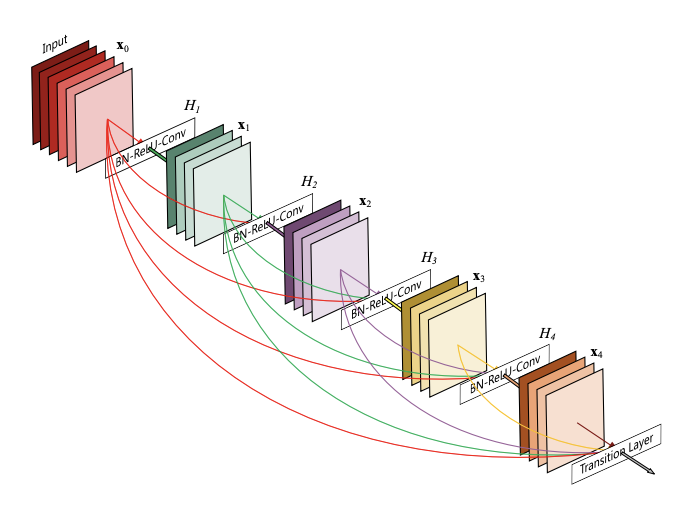

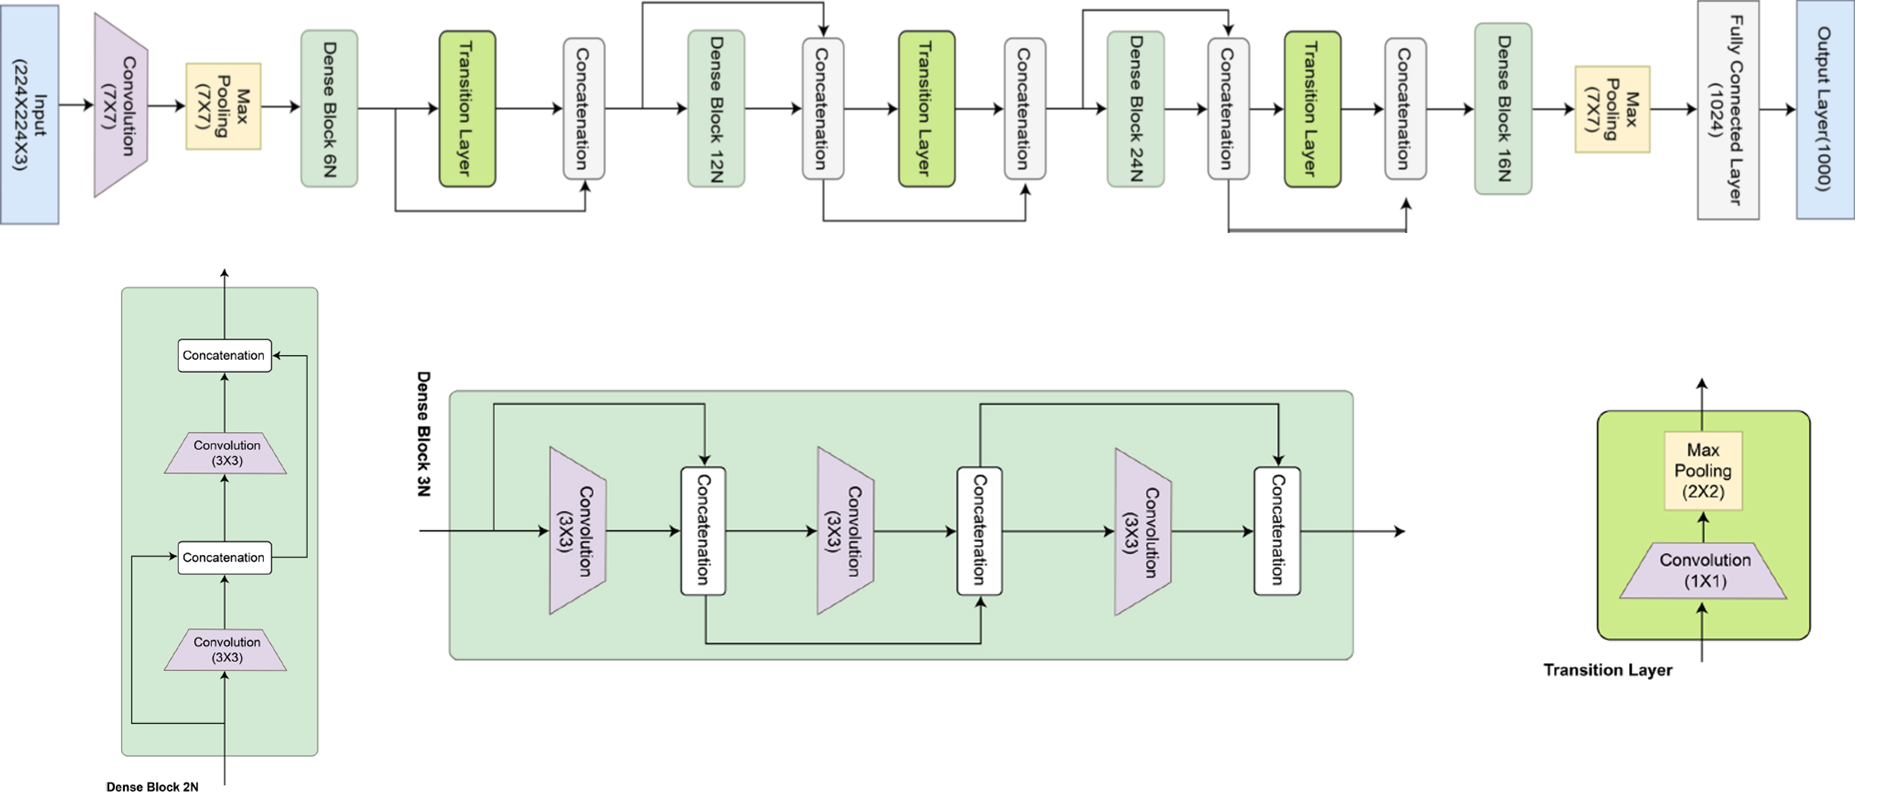

## Load Dataset

In [2]:
import os
# import pandas as pd
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

Definir transformaciones para el modelo DenseNet

In [42]:
# Transformaciones de datos para DenseNet
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
        'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [44]:
# Cargar los datos
data_dir = './working'
image_datasets = {x: ImageFolder(f'{data_dir}/{x}', data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes


In [5]:
class_names

['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

## Define Model and transfer learning

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Cargar el modelo DenseNet pre-entrenado
model = models.densenet121(pretrained=True)

# Congelar todos los parámetros
for param in model.parameters():
    param.requires_grad = False

# Modificar la última capa fully connected
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_names))

# Mover el modelo al dispositivo (GPU si está disponible)
model = model.to(device)

# Definir pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Planificador de tasa de aprendizaje
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

c:\ws\scm\github\mia\MIA203-NN-DL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ws\scm\github\mia\MIA203-NN-DL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
#!pip install torchsummary
!pip install torchinfo

In [ ]:
print(model)

In [19]:
from torchinfo import summary

In [ ]:
# Crear un tensor de entrada adecuado
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# Mostrar el resumen del modelo con el tensor de entrada
summary(model, input_data=input_tensor)

In [25]:
from torch.optim import lr_scheduler
import time
import copy
from tqdm import tqdm

In [26]:
# Función de entrenamiento
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

## Train model

In [37]:
# Entrenar el modelo
num_epochs = 100

In [38]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=num_epochs)

Epoch 0/99
----------


train: 100%|██████████| 329/329 [02:05<00:00,  2.63it/s]


train Loss: 0.1738 Acc: 0.9311


val: 100%|██████████| 94/94 [00:44<00:00,  2.09it/s]


val Loss: 0.0991 Acc: 0.9593

Epoch 1/99
----------


train: 100%|██████████| 329/329 [02:08<00:00,  2.55it/s]


train Loss: 0.1749 Acc: 0.9311


val: 100%|██████████| 94/94 [00:46<00:00,  2.02it/s]


val Loss: 0.0989 Acc: 0.9603

Epoch 2/99
----------


train: 100%|██████████| 329/329 [02:08<00:00,  2.55it/s]


train Loss: 0.1523 Acc: 0.9435


val: 100%|██████████| 94/94 [00:47<00:00,  1.98it/s]


val Loss: 0.0978 Acc: 0.9597

Epoch 3/99
----------


train: 100%|██████████| 329/329 [02:11<00:00,  2.51it/s]


train Loss: 0.1584 Acc: 0.9368


val: 100%|██████████| 94/94 [00:47<00:00,  1.99it/s]


val Loss: 0.0858 Acc: 0.9657

Epoch 4/99
----------


train: 100%|██████████| 329/329 [02:08<00:00,  2.56it/s]


train Loss: 0.1433 Acc: 0.9424


val: 100%|██████████| 94/94 [00:47<00:00,  1.99it/s]


val Loss: 0.0851 Acc: 0.9673

Epoch 5/99
----------


train: 100%|██████████| 329/329 [02:08<00:00,  2.56it/s]


train Loss: 0.1507 Acc: 0.9406


val: 100%|██████████| 94/94 [00:45<00:00,  2.08it/s]


val Loss: 0.0831 Acc: 0.9683

Epoch 6/99
----------


train: 100%|██████████| 329/329 [02:05<00:00,  2.62it/s]


train Loss: 0.1503 Acc: 0.9398


val: 100%|██████████| 94/94 [00:44<00:00,  2.09it/s]


val Loss: 0.0838 Acc: 0.9683

Epoch 7/99
----------


train: 100%|██████████| 329/329 [02:06<00:00,  2.60it/s]


train Loss: 0.1510 Acc: 0.9390


val: 100%|██████████| 94/94 [00:44<00:00,  2.10it/s]


val Loss: 0.0909 Acc: 0.9650

Epoch 8/99
----------


train: 100%|██████████| 329/329 [02:07<00:00,  2.59it/s]


train Loss: 0.1439 Acc: 0.9423


val: 100%|██████████| 94/94 [00:44<00:00,  2.09it/s]


val Loss: 0.0842 Acc: 0.9687

Epoch 9/99
----------


train: 100%|██████████| 329/329 [02:07<00:00,  2.58it/s]


train Loss: 0.1497 Acc: 0.9411


val: 100%|██████████| 94/94 [00:45<00:00,  2.07it/s]


val Loss: 0.0818 Acc: 0.9683

Epoch 10/99
----------


train: 100%|██████████| 329/329 [02:08<00:00,  2.56it/s]


train Loss: 0.1448 Acc: 0.9432


val: 100%|██████████| 94/94 [00:45<00:00,  2.06it/s]


val Loss: 0.0849 Acc: 0.9677

Epoch 11/99
----------


train: 100%|██████████| 329/329 [02:04<00:00,  2.64it/s]


train Loss: 0.1482 Acc: 0.9389


val: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


val Loss: 0.0852 Acc: 0.9677

Epoch 12/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.66it/s]


train Loss: 0.1446 Acc: 0.9416


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


val Loss: 0.0813 Acc: 0.9693

Epoch 13/99
----------


train: 100%|██████████| 329/329 [02:04<00:00,  2.65it/s]


train Loss: 0.1372 Acc: 0.9463


val: 100%|██████████| 94/94 [00:43<00:00,  2.14it/s]


val Loss: 0.0905 Acc: 0.9640

Epoch 14/99
----------


train: 100%|██████████| 329/329 [02:04<00:00,  2.64it/s]


train Loss: 0.1438 Acc: 0.9430


val: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]


val Loss: 0.0886 Acc: 0.9677

Epoch 15/99
----------


train: 100%|██████████| 329/329 [02:05<00:00,  2.62it/s]


train Loss: 0.1457 Acc: 0.9430


val: 100%|██████████| 94/94 [00:44<00:00,  2.13it/s]


val Loss: 0.0835 Acc: 0.9673

Epoch 16/99
----------


train: 100%|██████████| 329/329 [02:06<00:00,  2.60it/s]


train Loss: 0.1530 Acc: 0.9370


val: 100%|██████████| 94/94 [00:43<00:00,  2.14it/s]


val Loss: 0.0820 Acc: 0.9693

Epoch 17/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.66it/s]


train Loss: 0.1473 Acc: 0.9384


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


val Loss: 0.0938 Acc: 0.9643

Epoch 18/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.68it/s]


train Loss: 0.1458 Acc: 0.9442


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


val Loss: 0.0935 Acc: 0.9613

Epoch 19/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.66it/s]


train Loss: 0.1481 Acc: 0.9430


val: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


val Loss: 0.0817 Acc: 0.9693

Epoch 20/99
----------


train: 100%|██████████| 329/329 [02:04<00:00,  2.64it/s]


train Loss: 0.1465 Acc: 0.9406


val: 100%|██████████| 94/94 [00:43<00:00,  2.14it/s]


val Loss: 0.0993 Acc: 0.9587

Epoch 21/99
----------


train: 100%|██████████| 329/329 [02:06<00:00,  2.61it/s]


train Loss: 0.1442 Acc: 0.9410


val: 100%|██████████| 94/94 [00:44<00:00,  2.11it/s]


val Loss: 0.0842 Acc: 0.9667

Epoch 22/99
----------


train: 100%|██████████| 329/329 [02:05<00:00,  2.62it/s]


train Loss: 0.1459 Acc: 0.9435


val: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]


val Loss: 0.0874 Acc: 0.9677

Epoch 23/99
----------


train: 100%|██████████| 329/329 [02:05<00:00,  2.62it/s]


train Loss: 0.1454 Acc: 0.9422


val: 100%|██████████| 94/94 [00:44<00:00,  2.11it/s]


val Loss: 0.0938 Acc: 0.9647

Epoch 24/99
----------


train: 100%|██████████| 329/329 [02:05<00:00,  2.62it/s]


train Loss: 0.1457 Acc: 0.9440


val: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]


val Loss: 0.0983 Acc: 0.9603

Epoch 25/99
----------


train: 100%|██████████| 329/329 [02:06<00:00,  2.61it/s]


train Loss: 0.1404 Acc: 0.9430


val: 100%|██████████| 94/94 [00:45<00:00,  2.09it/s]


val Loss: 0.0925 Acc: 0.9633

Epoch 26/99
----------


train: 100%|██████████| 329/329 [02:05<00:00,  2.61it/s]


train Loss: 0.1449 Acc: 0.9434


val: 100%|██████████| 94/94 [00:45<00:00,  2.08it/s]


val Loss: 0.0924 Acc: 0.9623

Epoch 27/99
----------


train: 100%|██████████| 329/329 [02:06<00:00,  2.59it/s]


train Loss: 0.1445 Acc: 0.9415


val: 100%|██████████| 94/94 [00:45<00:00,  2.06it/s]


val Loss: 0.0779 Acc: 0.9710

Epoch 28/99
----------


train: 100%|██████████| 329/329 [02:05<00:00,  2.61it/s]


train Loss: 0.1404 Acc: 0.9445


val: 100%|██████████| 94/94 [00:44<00:00,  2.10it/s]


val Loss: 0.0856 Acc: 0.9677

Epoch 29/99
----------


train: 100%|██████████| 329/329 [02:07<00:00,  2.58it/s]


train Loss: 0.1482 Acc: 0.9423


val: 100%|██████████| 94/94 [00:45<00:00,  2.05it/s]


val Loss: 0.0820 Acc: 0.9683

Epoch 30/99
----------


train: 100%|██████████| 329/329 [02:04<00:00,  2.65it/s]


train Loss: 0.1457 Acc: 0.9412


val: 100%|██████████| 94/94 [00:42<00:00,  2.21it/s]


val Loss: 0.0806 Acc: 0.9697

Epoch 31/99
----------


train: 100%|██████████| 329/329 [02:01<00:00,  2.71it/s]


train Loss: 0.1453 Acc: 0.9430


val: 100%|██████████| 94/94 [00:42<00:00,  2.19it/s]


val Loss: 0.0846 Acc: 0.9663

Epoch 32/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.68it/s]


train Loss: 0.1454 Acc: 0.9416


val: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


val Loss: 0.0858 Acc: 0.9680

Epoch 33/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.69it/s]


train Loss: 0.1429 Acc: 0.9427


val: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


val Loss: 0.0805 Acc: 0.9713

Epoch 34/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.68it/s]


train Loss: 0.1397 Acc: 0.9459


val: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


val Loss: 0.0817 Acc: 0.9687

Epoch 35/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.70it/s]


train Loss: 0.1423 Acc: 0.9432


val: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


val Loss: 0.0916 Acc: 0.9660

Epoch 36/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.68it/s]


train Loss: 0.1439 Acc: 0.9427


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


val Loss: 0.0796 Acc: 0.9710

Epoch 37/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.67it/s]


train Loss: 0.1455 Acc: 0.9427


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


val Loss: 0.0861 Acc: 0.9680

Epoch 38/99
----------


train: 100%|██████████| 329/329 [02:01<00:00,  2.71it/s]


train Loss: 0.1466 Acc: 0.9433


val: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


val Loss: 0.0840 Acc: 0.9693

Epoch 39/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.69it/s]


train Loss: 0.1464 Acc: 0.9418


val: 100%|██████████| 94/94 [00:42<00:00,  2.19it/s]


val Loss: 0.0916 Acc: 0.9630

Epoch 40/99
----------


train: 100%|██████████| 329/329 [02:01<00:00,  2.70it/s]


train Loss: 0.1472 Acc: 0.9425


val: 100%|██████████| 94/94 [00:42<00:00,  2.19it/s]


val Loss: 0.1016 Acc: 0.9567

Epoch 41/99
----------


train: 100%|██████████| 329/329 [02:01<00:00,  2.71it/s]


train Loss: 0.1425 Acc: 0.9428


val: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


val Loss: 0.0879 Acc: 0.9677

Epoch 42/99
----------


train: 100%|██████████| 329/329 [02:01<00:00,  2.71it/s]


train Loss: 0.1490 Acc: 0.9397


val: 100%|██████████| 94/94 [00:42<00:00,  2.19it/s]


val Loss: 0.0895 Acc: 0.9647

Epoch 43/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.69it/s]


train Loss: 0.1501 Acc: 0.9418


val: 100%|██████████| 94/94 [00:43<00:00,  2.18it/s]


val Loss: 0.0806 Acc: 0.9713

Epoch 44/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.68it/s]


train Loss: 0.1385 Acc: 0.9456


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


val Loss: 0.0859 Acc: 0.9683

Epoch 45/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.67it/s]


train Loss: 0.1503 Acc: 0.9415


val: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]


val Loss: 0.0815 Acc: 0.9677

Epoch 46/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.70it/s]


train Loss: 0.1411 Acc: 0.9448


val: 100%|██████████| 94/94 [00:43<00:00,  2.18it/s]


val Loss: 0.0902 Acc: 0.9633

Epoch 47/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.67it/s]


train Loss: 0.1465 Acc: 0.9436


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


val Loss: 0.0949 Acc: 0.9627

Epoch 48/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.67it/s]


train Loss: 0.1454 Acc: 0.9410


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


val Loss: 0.1005 Acc: 0.9617

Epoch 49/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.66it/s]


train Loss: 0.1449 Acc: 0.9436


val: 100%|██████████| 94/94 [00:43<00:00,  2.18it/s]


val Loss: 0.0838 Acc: 0.9683

Epoch 50/99
----------


train: 100%|██████████| 329/329 [02:01<00:00,  2.70it/s]


train Loss: 0.1457 Acc: 0.9421


val: 100%|██████████| 94/94 [00:42<00:00,  2.19it/s]


val Loss: 0.0926 Acc: 0.9630

Epoch 51/99
----------


train: 100%|██████████| 329/329 [02:01<00:00,  2.70it/s]


train Loss: 0.1444 Acc: 0.9427


val: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


val Loss: 0.0851 Acc: 0.9670

Epoch 52/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.68it/s]


train Loss: 0.1455 Acc: 0.9418


val: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]


val Loss: 0.0834 Acc: 0.9653

Epoch 53/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.67it/s]


train Loss: 0.1466 Acc: 0.9422


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


val Loss: 0.0902 Acc: 0.9647

Epoch 54/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.69it/s]


train Loss: 0.1427 Acc: 0.9453


val: 100%|██████████| 94/94 [00:43<00:00,  2.14it/s]


val Loss: 0.0843 Acc: 0.9647

Epoch 55/99
----------


train: 100%|██████████| 329/329 [02:04<00:00,  2.65it/s]


train Loss: 0.1442 Acc: 0.9403


val: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


val Loss: 0.0783 Acc: 0.9713

Epoch 56/99
----------


train: 100%|██████████| 329/329 [02:04<00:00,  2.63it/s]


train Loss: 0.1414 Acc: 0.9441


val: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]


val Loss: 0.1005 Acc: 0.9587

Epoch 57/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.66it/s]


train Loss: 0.1523 Acc: 0.9378


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


val Loss: 0.0845 Acc: 0.9673

Epoch 58/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.68it/s]


train Loss: 0.1413 Acc: 0.9440


val: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]


val Loss: 0.0842 Acc: 0.9680

Epoch 59/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.67it/s]


train Loss: 0.1408 Acc: 0.9468


val: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


val Loss: 0.0897 Acc: 0.9650

Epoch 60/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.68it/s]


train Loss: 0.1443 Acc: 0.9415


val: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]


val Loss: 0.0883 Acc: 0.9677

Epoch 61/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.67it/s]


train Loss: 0.1517 Acc: 0.9396


val: 100%|██████████| 94/94 [00:43<00:00,  2.14it/s]


val Loss: 0.0873 Acc: 0.9670

Epoch 62/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.69it/s]


train Loss: 0.1401 Acc: 0.9436


val: 100%|██████████| 94/94 [00:42<00:00,  2.19it/s]


val Loss: 0.0949 Acc: 0.9630

Epoch 63/99
----------


train: 100%|██████████| 329/329 [02:01<00:00,  2.70it/s]


train Loss: 0.1446 Acc: 0.9443


val: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]


val Loss: 0.0936 Acc: 0.9590

Epoch 64/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.68it/s]


train Loss: 0.1399 Acc: 0.9444


val: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]


val Loss: 0.0866 Acc: 0.9643

Epoch 65/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.66it/s]


train Loss: 0.1492 Acc: 0.9421


val: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


val Loss: 0.0860 Acc: 0.9687

Epoch 66/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.69it/s]


train Loss: 0.1420 Acc: 0.9426


val: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]


val Loss: 0.0829 Acc: 0.9663

Epoch 67/99
----------


train: 100%|██████████| 329/329 [02:01<00:00,  2.71it/s]


train Loss: 0.1444 Acc: 0.9451


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


val Loss: 0.0850 Acc: 0.9657

Epoch 68/99
----------


train: 100%|██████████| 329/329 [02:01<00:00,  2.71it/s]


train Loss: 0.1446 Acc: 0.9424


val: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


val Loss: 0.0857 Acc: 0.9683

Epoch 69/99
----------


train: 100%|██████████| 329/329 [02:00<00:00,  2.74it/s]


train Loss: 0.1445 Acc: 0.9431


val: 100%|██████████| 94/94 [00:42<00:00,  2.21it/s]


val Loss: 0.0845 Acc: 0.9667

Epoch 70/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.70it/s]


train Loss: 0.1430 Acc: 0.9426


val: 100%|██████████| 94/94 [00:44<00:00,  2.13it/s]


val Loss: 0.0879 Acc: 0.9647

Epoch 71/99
----------


train: 100%|██████████| 329/329 [02:00<00:00,  2.74it/s]


train Loss: 0.1497 Acc: 0.9391


val: 100%|██████████| 94/94 [00:42<00:00,  2.21it/s]


val Loss: 0.0845 Acc: 0.9683

Epoch 72/99
----------


train: 100%|██████████| 329/329 [02:00<00:00,  2.73it/s]


train Loss: 0.1393 Acc: 0.9460


val: 100%|██████████| 94/94 [00:42<00:00,  2.21it/s]


val Loss: 0.0849 Acc: 0.9667

Epoch 73/99
----------


train: 100%|██████████| 329/329 [01:59<00:00,  2.75it/s]


train Loss: 0.1423 Acc: 0.9436


val: 100%|██████████| 94/94 [00:42<00:00,  2.22it/s]


val Loss: 0.1046 Acc: 0.9570

Epoch 74/99
----------


train: 100%|██████████| 329/329 [02:00<00:00,  2.73it/s]


train Loss: 0.1493 Acc: 0.9412


val: 100%|██████████| 94/94 [00:42<00:00,  2.21it/s]


val Loss: 0.0821 Acc: 0.9707

Epoch 75/99
----------


train: 100%|██████████| 329/329 [01:59<00:00,  2.76it/s]


train Loss: 0.1469 Acc: 0.9424


val: 100%|██████████| 94/94 [00:43<00:00,  2.18it/s]


val Loss: 0.0895 Acc: 0.9660

Epoch 76/99
----------


train: 100%|██████████| 329/329 [02:00<00:00,  2.72it/s]


train Loss: 0.1464 Acc: 0.9408


val: 100%|██████████| 94/94 [00:42<00:00,  2.22it/s]


val Loss: 0.0900 Acc: 0.9660

Epoch 77/99
----------


train: 100%|██████████| 329/329 [02:00<00:00,  2.73it/s]


train Loss: 0.1465 Acc: 0.9419


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


val Loss: 0.0804 Acc: 0.9703

Epoch 78/99
----------


train: 100%|██████████| 329/329 [02:00<00:00,  2.72it/s]


train Loss: 0.1428 Acc: 0.9429


val: 100%|██████████| 94/94 [00:43<00:00,  2.18it/s]


val Loss: 0.0892 Acc: 0.9660

Epoch 79/99
----------


train: 100%|██████████| 329/329 [01:59<00:00,  2.75it/s]


train Loss: 0.1409 Acc: 0.9458


val: 100%|██████████| 94/94 [00:43<00:00,  2.14it/s]


val Loss: 0.0825 Acc: 0.9670

Epoch 80/99
----------


train: 100%|██████████| 329/329 [01:59<00:00,  2.76it/s]


train Loss: 0.1516 Acc: 0.9386


val: 100%|██████████| 94/94 [00:41<00:00,  2.24it/s]


val Loss: 0.0954 Acc: 0.9593

Epoch 81/99
----------


train: 100%|██████████| 329/329 [01:59<00:00,  2.76it/s]


train Loss: 0.1396 Acc: 0.9462


val: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


val Loss: 0.1019 Acc: 0.9597

Epoch 82/99
----------


train: 100%|██████████| 329/329 [01:59<00:00,  2.75it/s]


train Loss: 0.1407 Acc: 0.9444


val: 100%|██████████| 94/94 [00:42<00:00,  2.22it/s]


val Loss: 0.0895 Acc: 0.9643

Epoch 83/99
----------


train: 100%|██████████| 329/329 [01:58<00:00,  2.77it/s]


train Loss: 0.1469 Acc: 0.9409


val: 100%|██████████| 94/94 [00:43<00:00,  2.19it/s]


val Loss: 0.0800 Acc: 0.9713

Epoch 84/99
----------


train: 100%|██████████| 329/329 [01:58<00:00,  2.77it/s]


train Loss: 0.1461 Acc: 0.9424


val: 100%|██████████| 94/94 [00:42<00:00,  2.19it/s]


val Loss: 0.0986 Acc: 0.9610

Epoch 85/99
----------


train: 100%|██████████| 329/329 [01:59<00:00,  2.76it/s]


train Loss: 0.1494 Acc: 0.9416


val: 100%|██████████| 94/94 [00:42<00:00,  2.23it/s]


val Loss: 0.0905 Acc: 0.9660

Epoch 86/99
----------


train: 100%|██████████| 329/329 [01:59<00:00,  2.76it/s]


train Loss: 0.1490 Acc: 0.9405


val: 100%|██████████| 94/94 [00:42<00:00,  2.23it/s]


val Loss: 0.0820 Acc: 0.9687

Epoch 87/99
----------


train: 100%|██████████| 329/329 [01:59<00:00,  2.75it/s]


train Loss: 0.1472 Acc: 0.9421


val: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


val Loss: 0.0832 Acc: 0.9693

Epoch 88/99
----------


train: 100%|██████████| 329/329 [01:59<00:00,  2.76it/s]


train Loss: 0.1401 Acc: 0.9440


val: 100%|██████████| 94/94 [00:42<00:00,  2.23it/s]


val Loss: 0.0828 Acc: 0.9697

Epoch 89/99
----------


train: 100%|██████████| 329/329 [01:58<00:00,  2.78it/s]


train Loss: 0.1413 Acc: 0.9433


val: 100%|██████████| 94/94 [00:42<00:00,  2.22it/s]


val Loss: 0.0814 Acc: 0.9677

Epoch 90/99
----------


train: 100%|██████████| 329/329 [01:57<00:00,  2.79it/s]


train Loss: 0.1464 Acc: 0.9419


val: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


val Loss: 0.0821 Acc: 0.9700

Epoch 91/99
----------


train: 100%|██████████| 329/329 [02:00<00:00,  2.73it/s]


train Loss: 0.1415 Acc: 0.9434


val: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


val Loss: 0.0880 Acc: 0.9650

Epoch 92/99
----------


train: 100%|██████████| 329/329 [02:00<00:00,  2.72it/s]


train Loss: 0.1423 Acc: 0.9435


val: 100%|██████████| 94/94 [00:42<00:00,  2.19it/s]


val Loss: 0.0801 Acc: 0.9703

Epoch 93/99
----------


train: 100%|██████████| 329/329 [02:01<00:00,  2.71it/s]


train Loss: 0.1454 Acc: 0.9399


val: 100%|██████████| 94/94 [00:43<00:00,  2.18it/s]


val Loss: 0.0863 Acc: 0.9680

Epoch 94/99
----------


train: 100%|██████████| 329/329 [02:01<00:00,  2.70it/s]


train Loss: 0.1455 Acc: 0.9428


val: 100%|██████████| 94/94 [00:43<00:00,  2.18it/s]


val Loss: 0.0880 Acc: 0.9657

Epoch 95/99
----------


train: 100%|██████████| 329/329 [02:00<00:00,  2.73it/s]


train Loss: 0.1419 Acc: 0.9453


val: 100%|██████████| 94/94 [00:42<00:00,  2.19it/s]


val Loss: 0.0861 Acc: 0.9700

Epoch 96/99
----------


train: 100%|██████████| 329/329 [02:03<00:00,  2.66it/s]


train Loss: 0.1467 Acc: 0.9421


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]


val Loss: 0.0841 Acc: 0.9670

Epoch 97/99
----------


train: 100%|██████████| 329/329 [02:01<00:00,  2.70it/s]


train Loss: 0.1438 Acc: 0.9407


val: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


val Loss: 0.0962 Acc: 0.9600

Epoch 98/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.68it/s]


train Loss: 0.1473 Acc: 0.9424


val: 100%|██████████| 94/94 [00:42<00:00,  2.19it/s]


val Loss: 0.0887 Acc: 0.9640

Epoch 99/99
----------


train: 100%|██████████| 329/329 [02:02<00:00,  2.69it/s]


train Loss: 0.1455 Acc: 0.9432


val: 100%|██████████| 94/94 [00:43<00:00,  2.17it/s]

val Loss: 0.0807 Acc: 0.9700

Training complete in 277m 35s
Best val Acc: 0.971333


In [39]:
# Guardar el modelo entrenado
torch.save(model.state_dict(), 'densenet_lung_cancer.pth')

# Evaluate model

In [40]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}%')

In [45]:

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, dataloaders['test'])

Accuracy on the test set: 96.74%


In [46]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

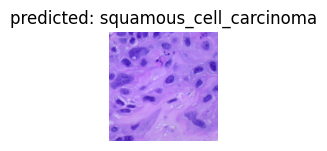

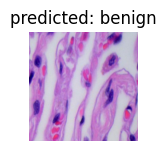

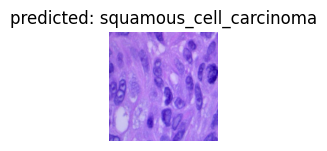

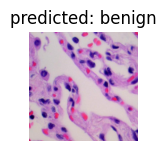

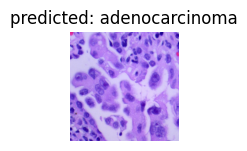

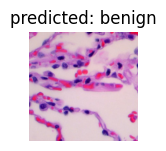

In [47]:
# Visualizar algunas predicciones
visualize_model(model)
plt.show()

## Prediccion

In [13]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_and_visualize(model, image_path, class_names, device):
    # Cargar y preprocesar la imagen
    img = Image.open(image_path)
    
    # Definir las transformaciones (asegúrate de que coincidan con las usadas durante el entrenamiento)
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # Tamaño requerido para Inception_v3
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Aplicar transformaciones
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Realizar la predicción
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Para manejar las salidas auxiliares de Inception_v3
        _, predicted = torch.max(outputs, 1)
        
    # Obtener la etiqueta predicha
    predicted_label = class_names[predicted.item()]
    
    # Visualizar la imagen y la predicción
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicción: {predicted_label}')
    plt.show()
    
    return predicted_label

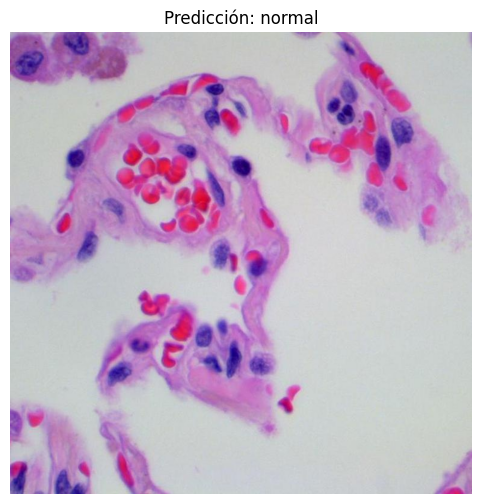

La imagen es clasificada como: normal


In [39]:
# Asegúrate de que tu modelo esté cargado y en el dispositivo correcto
# model = ...  # Tu modelo Inception_v3 cargado y entrenado
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Tus nombres de clases
class_names = ['adenocarcinoma', 'normal', 'squamous cell carcinoma']  # Ajusta según tus clases reales

# Ruta a la imagen que quieres clasificar
#image_path = "./working/test/adenocarcinoma/0005.jpg"
image_path = "./working/test/benign/0282.jpg"
#image_path = "./working/test/squamous_cell_carcinoma/4999.jpg"
#image_path = "./0647.jpg"



# Realizar la predicción y visualizar
predicted_label = predict_and_visualize(model, image_path, class_names, device)
print(f"La imagen es clasificada como: {predicted_label}")

In [49]:
import torch
from torchvision import models

# Cargar el modelo DenseNet121 preentrenado
model = models.densenet121(pretrained=True)

# Contar el número total de parámetros y los entrenables
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.classifier.parameters() if p.requires_grad)

print(f"Número total de parámetros: {total_params}")
print(f"Parámetros entrenables: {trainable_params}")

Número total de parámetros: 7978856
Parámetros entrenables: 1025000


c:\ws\scm\github\mia\MIA203-NN-DL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ws\scm\github\mia\MIA203-NN-DL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
import torch
from torchvision import models

# Cargar el modelo DenseNet121 preentrenado
model_1 = models.densenet121(pretrained=True)

# Imprimir la estructura del modelo (para verificar la capa de clasificación)
print(model)

# Obtener los parámetros de la capa de clasificación (no convolucional)
classifier_params = model.classifier.parameters()

# Contar los parámetros entrenables solo en la capa de clasificación
trainable_params = sum(p.numel() for p in classifier_params if p.requires_grad)

print(f"Parámetros entrenables en la capa no convolucional (classifier): {trainable_params}")

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

c:\ws\scm\github\mia\MIA203-NN-DL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ws\scm\github\mia\MIA203-NN-DL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
